In [1]:
# image_dir = "./Flickr8k_dataset/Images" # 원본 이미지 파일 경로
# train_image_dir = "./resized_train/images" # 크기가 조정된 이미지가 담길 경로 (학습)
# val_image_dir = "./resized_val/images" # 크기가 조정된 이미지가 담길 경로 (평가)
# test_image_dir = "./resized_test/images" # 크기가 조정된 이미지가 담길 경로 (테스트)
# size = [256, 256] # 조정될 이미지 크기


# def resize_image(image, size):
#     # 이미지를 특정 크기로 조정
#     return image.resize(size, Image.ANTIALIAS)

# # image_dir 내부에 있는 모든 이미지의 크기를 바꾸어 결과 폴더로 옮기기
# if not os.path.exists(train_image_dir):
#     os.makedirs(train_image_dir)
# if not os.path.exists(val_image_dir):
#     os.makedirs(val_image_dir)
# if not os.path.exists(test_image_dir):
#     os.makedirs(test_image_dir)

# images = sorted(os.listdir(image_dir)) # 이미지와 캡션 모두 파일 이름별로 정렬해서 매칭
# num_images = len(images)
# num_train_images = 6000 # 6000개는 학습용 데이터로 이용
# num_val_images = 1000 # 1000개는 평가용 데이터로 이용
# # 나머지 1000개는 테스트용 데이터로 이용

# for i, image in enumerate(images):
#     if (i + 1) <= num_train_images:
#         output_dir = train_image_dir
#     elif (i + 1) <= num_train_images + num_val_images:
#         output_dir = val_image_dir
#     else:
#         output_dir = test_image_dir
#     with open(os.path.join(image_dir, image), 'rb+') as f:
#         with Image.open(f) as img:
#             img = resize_image(img, size)
#             img.save(os.path.join(output_dir, image), img.format)
#     if (i + 1) % 500 == 0:
#         print(f"[{i + 1}/{num_images}] Resized the images and saved into '{output_dir}'")

In [2]:
# data = pd.read_csv(caption_file)


# data.head()

### Reference 
* [Tensorflow 눈에 띠는 이미지 캡션](https://www.tensorflow.org/tutorials/text/image_captioning#ms-coco_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%84%B8%ED%8A%B8_%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C_%EB%B0%8F_%EC%A4%80%EB%B9%84)

* [ndb796/PyTorch-Neural-Image-Caption-Generator](https://github.com/ndb796/PyTorch-Neural-Image-Caption-Generator/blob/main/Neural_Image_Captioning_(NIC)_using_ResNet_101.ipynb)



In [3]:
import sys
print(sys.version)

3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]


In [4]:
import tensorflow as tf


import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

# 추가
import csv
import pandas as pd


## Flickr8k 데이터세트 다운로드

[Flickr 8K Images with Captions](https://www.kaggle.com/kunalgupta2616/flickr-8k-images-with-captions)에서 Flickr8k 데이터 다운로드

8000개의 이미지와 40,000개의 캡션을 사용하여 모델을 훈련


위 코드와 아래 코드를 맞게 수정할 것

위 예시에서는 6000장으로 훈련하기 때문에 아마도 잘 될듯?


captions 가 txt로 되어있는데 ,로 구분되어있어서 **csv 파일 확장자**로 바꾸었음

In [5]:
caption_file = './Flickr8k_dataset/captions_csv.csv'

f = open(caption_file, 'r', encoding='utf8')
rdr = list(csv.reader(f))[1:] # [0] -> image, caption

print(rdr[0])
print(rdr[0][0]) # -> img
print(rdr[0][1]) # -> caption

f.close()

['1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .']
1000268201_693b08cb0e.jpg
A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
image_path_to_caption = collections.defaultdict(list)

for val in rdr :
    image_path = './Flickr8k_dataset/Images/' + val[0]
    caption = f"<start> {val[1]} <end>"
    image_path_to_caption[image_path].append(caption)

In [7]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# 랜덤하게 섞은 리스트에서 처음 6,000개의 image_paths 를 선택합니다.
# 각각의 이미지는 5개의 캡션과 연결되어 있습니다.
# 훈련 데이터는 총 이미지 6,000개와 캡션 30,000개가 있습니다

train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [8]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

<start> A dog is near three farm animals with horns outside . <end>


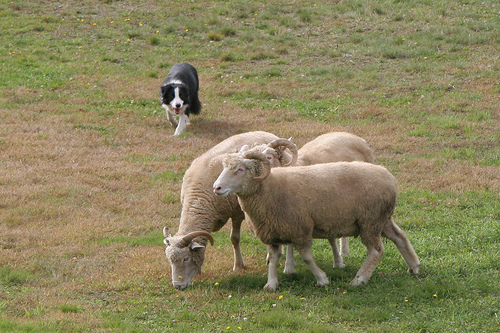

In [9]:
print(train_captions[0])
Image.open(img_name_vector[0])

## InceptionV3를 사용하여 이미지 전처리하기

다음으로, (Imagenet에 대해 사전 훈련된) InceptionV3을 사용하여 각 이미지를 분류합니다. 마지막 컨볼루셔널 레이어에서 특성을 추출합니다.

먼저 다음을 수행하여 이미지를 InceptionV3의 예상 형식으로 변환합니다.

* 이미지를 299px x 299px로 크기 조정합니다.

* preprocess_input 메서드로 이미지를 사전 처리하여 -1에서 1 범위의 픽셀을 포함하도록 이미지를 정규화합니다. 이는 InceptionV3를 훈련하는 데 사용되는 이미지의 형식과 일치합니다.

In [11]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (15, 15))
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, image_path

## InceptionV3 초기화 및 사전 훈련된 Imagenet 가중치 로드하기

이제 출력 레이어가 InceptionV3 아키텍처의 마지막 컨볼루셔널 레이어인 tf.keras 모델을 만듭니다. 이 레이어의 출력 형상은 8x8x2048입니다. 이 예제에서는 attention을 사용하므로 마지막 컨볼루셔널 레이어를 사용합니다. 병목 현상이 발생할 수 있으므로 훈련 중에는 이 초기화를 수행하지 마세요.

* 네트워크를 통해 각 이미지를 전달하고 결과 벡터를 사전 (image_name --> feature_vector)에 저장합니다.

* 모든 이미지가 네트워크를 통해 전달된 후, 사전을 디스크에 저장합니다.

In [12]:
image_model = tf.keras.applications.resnet.ResNet101(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## InceptionV3에서 추출된 특성 캐시하기

InceptionV3로 각 이미지를 사전 처리하고 출력을 디스크에 캐시합니다. RAM에 출력을 캐시하는 것이 더 빠르지만, 메모리를 많이 사용하므로 이미지당 8 * 8 * 2048 부동 소수점이 필요합니다. 본 튜토리얼을 작성할 시점에서 Colab의 메모리 제한(현재 12GB의 메모리)을 초과합니다.

보다 정교한 캐싱 전략(예를 들어, 임의 액세스 디스크 I/O를 줄이기 위해 이미지를 분할)으로 성능을 향상할 수 있지만, 더 많은 코드가 필요합니다.

캐싱은 GPU로 Colab에서 실행하는 데 약 10분이 걸립니다. 진행률 표시줄을 보려면 다음을 수행합니다.

1. tqdm을 설치합니다. <br> `!pip install tqdm`


2. tqdm를 가져옵니다. <br> `from tqdm import tqdm`


3. 다음 줄을 <br> `for img, path in image_dataset:` <br>
   다음으로 변경합니다. <br> `for img, path in tqdm(image_dataset):`


In [ ]:
from tqdm import tqdm


# Get unique images
encode_train = sorted(set(img_name_vector)) 

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

  0%|                                                                                          | 0/375 [00:00<?, ?it/s]

### Error...
Could not load library cudnn_cnn_infer64_8.dll. Error code 126
Please make sure cudnn_cnn_infer64_8.dll is in your library path!